In [ ]:
!wget https://raw.githubusercontent.com/Apress/applied-data-science-using-pyspark/main/Ch09/bank-full.csv

--2023-02-17 14:26:16--  https://raw.githubusercontent.com/Apress/applied-data-science-using-pyspark/main/Ch09/bank-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [text/plain]
Saving to: ‘bank-full.csv’

bank-full.csv       100%[===================>]   4.40M  --.-KB/s    in 0.01s   

2023-02-17 14:26:16 (306 MB/s) - ‘bank-full.csv’ saved [4610348/4610348]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.csv("bank-full.csv", header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [ ]:
#convert target column variable to numeric
from pyspark.sql import functions as F
df = df.withColumn('y', F.when(F.col("y") == 'yes',1).otherwise(0))

In [ ]:
##datatype of each column and treat them accordingly
def variable_type(df):
  vars_list = df.dtypes
  char_vars = []
  num_vars = []
  for i in vars_list:
    if i[1] in ('string'):
      char_vars.append(i[0])
    else:
      num_vars.append(i[0])
  return char_vars,num_vars

In [ ]:
char_vars, num_vars = variable_type(df)

In [ ]:
target_variable_name = "y"
num_vars.remove(target_variable_name)

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [ ]:
##convert categorical to numeric using label encoder option
def category_to_index(df, char_vars):

  char_df = df.select(char_vars)
  indexers = [StringIndexer(inputCol=c, outputCol=c+"_index",
                            handleInvalid="keep") for c in char_df.columns]
  pipeline = Pipeline(stages=indexers)
  char_labels = pipeline.fit(char_df)
  df = char_labels.transform(df)
  return df, char_labels


In [ ]:
df, char_labels = category_to_index(df, char_vars)
df = df.select([c for c in df.columns if c not in char_vars])

In [ ]:
def rename_columns(df, char_vars):
  mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
  df = df.select([F.col(c).alias(mapping.get(c,c)) for c in df.columns])

  return df

In [ ]:
df = rename_columns(df, char_vars)


In [ ]:
df.show()

+---+-------+---+--------+--------+-----+--------+---+----+-------+---------+-------+-------+----+-------+-----+--------+
|age|balance|day|duration|campaign|pdays|previous|  y| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+-------+---+--------+--------+-----+--------+---+----+-------+---------+-------+-------+----+-------+-----+--------+
| 58|   2143|  5|     261|       1|   -1|       0|  0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 44|     29|  5|     151|       1|   -1|       0|  0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 33|      2|  5|      76|       1|   -1|       0|  0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
| 47|   1506|  5|      92|       1|   -1|       0|  0| 0.0|    0.0|      3.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
| 33|      1|  5|     198|       1|   -1|       0|  0|11.0|    1.0|      3.0|    0.0|    1.0| 0.0|    1.0|  0.0|     0.0|
| 35|    231|  5|     13

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
def assemble_vectors(df, features_list, target_variable_name):
  stages = []
  #assemble vectors
  assembler = VectorAssembler(inputCols=features_list,
                              outputCol='features')
  stages=[assembler]
  #select all the columns + target + newly created 'features' column
  selectedCols = [target_variable_name, 'features'] + features_list
  #use pipeline to process sequentially
  pipeline = Pipeline(stages=stages)
  #assembler model
  assembleModel = pipeline.fit(df)
  #apply assembler model on data
  df = assembleModel.transform(df).select(selectedCols)

  return df, assembleModel, selectedCols

In [ ]:
##exclude target variable and select all other feature vectors
features_list = df.columns
features_list.remove(target_variable_name)

In [ ]:
## apply the function on our Dataframe
df, assembleModel, selectedCols = assemble_vectors(df, features_list, target_variable_name)

In [ ]:
## train test split
train, test = df.randomSplit([0.7,0.3], seed=12345)

In [ ]:
train.count() , test.count()

(31527, 13684)

In [ ]:
##Random Forest Model
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(featuresCol='features', labelCol='y')
clf_model = clf.fit(train)
print(clf_model.featureImportances)
print(clf_model.toDebugString)
train_pred_result = clf_model.transform(train)
test_pred_result = clf_model.transform(test)

(16,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],[0.018582336841372053,0.011884996352216192,0.005957331614977746,0.51325178319009,0.003295308737052858,0.07477875895564604,0.038843596797758104,0.004785016471433819,0.0019392910397189316,0.0007224763299857643,7.328177665528677e-05,0.04987920428038465,0.0018209721976935346,0.020499857327493053,0.07735113190824491,0.17633465617927702])
RandomForestClassificationModel: uid=RandomForestClassifier_3d15ce8260f5, numTrees=20, numClasses=2, numFeatures=16
  Tree 0 (weight 1.0):
    If (feature 3 <= 486.5)
     If (feature 5 <= 20.0)
      Predict: 0.0
     Else (feature 5 > 20.0)
      If (feature 15 in {0.0,1.0,2.0})
       Predict: 0.0
      Else (feature 15 not in {0.0,1.0,2.0})
       If (feature 4 <= 6.5)
        Predict: 1.0
       Else (feature 4 > 6.5)
        Predict: 0.0
    Else (feature 3 > 486.5)
     If (feature 11 in {1.0})
      If (feature 6 <= 0.5)
       If (feature 8 in {1.0,2.0})
        If (feature 14 in {10.0,11.0})
         Pre

In [ ]:
#validate the random forest model
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType

In [ ]:
def evaluation_metrics(df, target_variable_name):
  pred = df.select("prediction", target_variable_name)
  pred = pred.withColumn(target_variable_name, pred[target_variable_name].cast(DoubleType()))
  pred = pred.withColumn("prediction", pred["prediction"].cast(DoubleType()))
  metrics = MulticlassMetrics(pred.rdd.map(tuple))
  #confusion matrix
  cm = metrics.confusionMatrix().toArray()
  acc = metrics.accuracy 
  misclassification_rate = 1 - acc
  precision = metrics.precision(1.0)
  recall = metrics.recall(1.0)
  f1 = metrics.fMeasure(1.0)
  #roc value
  evaluator_roc = BinaryClassificationEvaluator(
      labelCol=target_variable_name, rawPredictionCol='rawPrediction',metricName='areaUnderROC'
  )
  roc = evaluator_roc.evaluate(df)
  evaluator_pr = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction',metricName='areaUnderPR')
  pr = evaluator_pr.evaluate(df)
  
  return cm, acc, misclassification_rate, precision, recall, f1, roc, pr


In [ ]:
train_cm, train_acc, train_miss_rate, train_precision, \
train_recall, train_f1, train_roc, train_pr = evaluation_metrics(train_pred_result, target_variable_name)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
test_cm, test_acc, test_miss_rate, test_precision, \
test_recall, test_f1, test_roc, test_pr = evaluation_metrics(test_pred_result, target_variable_name)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print('Train accuracy - ', train_acc, ', Test accuracy - ', test_acc)

Train accuracy -  0.8933929647603641 , Test accuracy -  0.8922098801520023


In [ ]:
print('Train misclassification rate - ', train_miss_rate, ', Test misclassification rate - ', test_miss_rate)

Train misclassification rate -  0.10660703523963588 , Test misclassification rate -  0.10779011984799769


In [ ]:
print('Train precision - ', train_precision, ', Test precision - ', test_precision)

Train precision -  0.8225806451612904 , Test precision -  0.8151658767772512


In [ ]:
print('Train recall - ', train_recall, ', Test recall - ', test_recall)

Train recall -  0.11083944580277098 , Test recall -  0.10696517412935323


In [ ]:
print('Train f1 score - ', train_f1, ', Test f1 score - ', test_f1)

Train f1 score -  0.19535551831457984 , Test f1 score -  0.18911489829576691


In [ ]:
print('Train ROC - ', train_roc, ', Test ROC - ', test_roc)

Train ROC -  0.8906824886977339 , Test ROC -  0.8877679907435331


In [ ]:
print('Train PR - ', train_pr, ', Test PR - ', test_pr)

Train PR -  0.5639005268105522 , Test PR -  0.551935013081952


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def make_cm_chart(cf_matrix_train, cf_matrix_test):

  list_values = ['0','1']

  plt.figure(1, figsize=(10,5))
  plt.subplot(121)
  sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values,
              xticklabels=list_values, fmt='g')
  plt.ylabel('Actual')
  plt.xlabel("Pred")
  plt.ylim([0, len(list_values)])
  plt.title('Train data predictions')

  plt.subplot(122)
  sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values,
              xticklabels=list_values, fmt='g')
  plt.ylabel("Actual")
  plt.xlabel("Pred")
  plt.ylim([0, len(list_values)])
  plt.title("Test data predictions")

  plt.tight_layout()
  return None

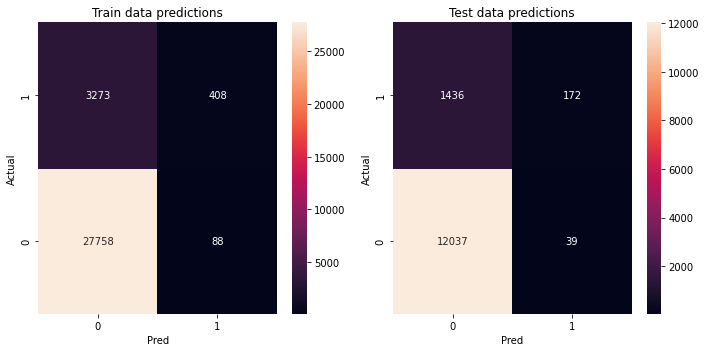

In [ ]:
make_cm_chart(train_cm, test_cm)

In [ ]:
## Make ROC Chart and PR Curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
  def __init__(self, *args):
    super(CurveMetrics, self).__init__(*args)

  def _to_list(self, rdd):
    points = []
    results_collect = rdd.collect()
    for row in results_collect:
      points += [(float(row._1()), float(row._2()))]
    return points

  def get_curve(self, method):
    rdd = getattr(self._java_model, method)().toJavaRDD()
    return  self._to_list(rdd)


In [ ]:
def plot_roc_pr(df, target_variable_name, plot_type, legend_value, title):

  preds = df.select(target_variable_name, 'probability')
  preds = preds.rdd.map(lambda row: (float(row['probability'][1]),float(row[target_variable_name])))
  ## Returns as a list
  points = CurveMetrics(preds).get_curve(plot_type)
  plt.figure()
  x_val = [x[0] for x in points]
  y_val = [y[0] for y in points]
  plt.title(title)

  if plot_type == 'roc':
    plt.xlabel("False Positive Rate (1- Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.plot(x_val, y_val, label= 'AUC = %0.2f' % legend_value)
    plt.plot([0,1], [0,1], color='red', linestyle='--')

  if plot_type == 'pr':
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(x_val, y_val, label= 'Average Precision = %0.2f' % legend_value)
    plt.plot([0,1], [0.5 , 0.5], color='red', linestyle='--')

  plt.legend(loc ='lower right')
  return None

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


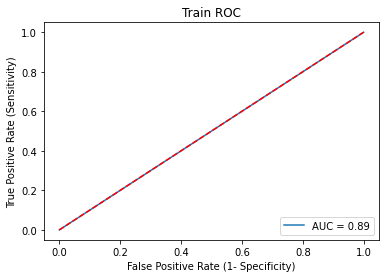

In [ ]:
plot_roc_pr(train_pred_result, target_variable_name, 'roc', train_roc, 'Train ROC')

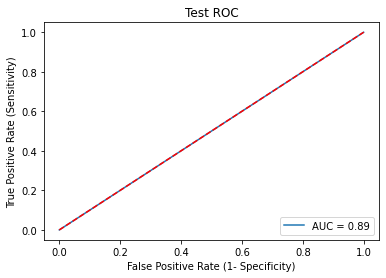

In [ ]:
plot_roc_pr(test_pred_result, target_variable_name, 'roc', test_roc, 'Test ROC')

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


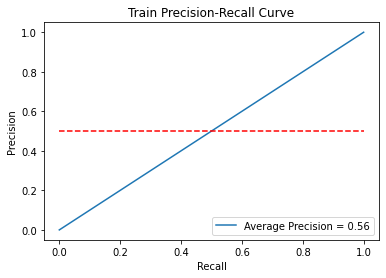

In [ ]:
plot_roc_pr(train_pred_result, target_variable_name, 'pr', train_pr, 'Train Precision-Recall Curve')

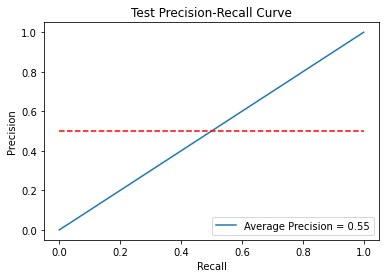

In [ ]:
plot_roc_pr(test_pred_result, target_variable_name, 'pr', test_pr, 'Test Precision-Recall Curve')

In [ ]:
import pickle

In [ ]:
char_labels.write().overwrite().save('char_label_model.h5')

In [ ]:
assembleModel.write().overwrite().save('assembleModel.h5')

In [ ]:
clf_model.write().overwrite().save('clf_model.h5')

In [ ]:
list_of_vars = [features_list, char_vars, num_vars]
with open('file.pkl','wb') as handle:
  pickle.dump(list_of_vars, handle)

In [ ]:
!zip -r /content/assembleModel.zip /content/assembleModel.h5

  adding: content/assembleModel.h5/ (stored 0%)
  adding: content/assembleModel.h5/stages/ (stored 0%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/ (stored 0%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/metadata/ (stored 0%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/metadata/_SUCCESS (stored 0%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/metadata/.part-00000.crc (stored 0%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/metadata/part-00000 (deflated 40%)
  adding: content/assembleModel.h5/stages/0_VectorAssembler_9be2e2b0d9fd/metadata/._SUCCESS.crc (stored 0%)
  adding: content/assembleModel.h5/metadata/ (stored 0%)
  adding: content/assembleModel.h5/metadata/_SUCCESS (stored 0%)
  adding: content/assembleModel.h5/metadata/.part-00000.crc (stored 0%)
  adding: content/assembleModel.h5/metadata/part-00000 (deflated 22%)
  adding: content/assem

In [ ]:
!zip -r /content/charmodel.zip /content/char_label_model.h5

  adding: content/char_label_model.h5/ (stored 0%)
  adding: content/char_label_model.h5/stages/ (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/ (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/data/ (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/data/_SUCCESS (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/data/._SUCCESS.crc (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/data/.part-00000-539631a3-bafe-4e2a-bec2-6ae777feb8ab-c000.snappy.parquet.crc (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/data/part-00000-539631a3-bafe-4e2a-bec2-6ae777feb8ab-c000.snappy.parquet (deflated 36%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/metadata/ (stored 0%)
  adding: content/char_label_model.h5/stages/6_StringIndexer_4d82ca53e374/metadata/_S

In [ ]:
!zip -r /content/clfmodel.zip /content/clf_model.h5

  adding: content/clf_model.h5/ (stored 0%)
  adding: content/clf_model.h5/data/ (stored 0%)
  adding: content/clf_model.h5/data/_SUCCESS (stored 0%)
  adding: content/clf_model.h5/data/._SUCCESS.crc (stored 0%)
  adding: content/clf_model.h5/data/.part-00000-35561048-4f4f-4cdb-b5ba-0829f1dd3534-c000.snappy.parquet.crc (stored 0%)
  adding: content/clf_model.h5/data/part-00000-35561048-4f4f-4cdb-b5ba-0829f1dd3534-c000.snappy.parquet (deflated 20%)
  adding: content/clf_model.h5/treesMetadata/ (stored 0%)
  adding: content/clf_model.h5/treesMetadata/_SUCCESS (stored 0%)
  adding: content/clf_model.h5/treesMetadata/._SUCCESS.crc (stored 0%)
  adding: content/clf_model.h5/treesMetadata/part-00000-381d0e88-78e1-45be-9d36-5a470b6a190f-c000.snappy.parquet (deflated 39%)
  adding: content/clf_model.h5/treesMetadata/.part-00000-381d0e88-78e1-45be-9d36-5a470b6a190f-c000.snappy.parquet.crc (stored 0%)
  adding: content/clf_model.h5/metadata/ (stored 0%)
  adding: content/clf_model.h5/metadata/_S